In [1]:
import circle_packing as cp
import starting_k_grouping as kg
import series_ordering as so
import parallel_plate as pp
import series_plate as sp


from pathlib import Path
from shapely.geometry import Point, Polygon, LineString
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

json_file = "input_rect.json"  # Path to the input JSON file
out_csv = "out.csv"
R = 9.0  # mm, radius of an 18650 seen from the top
EPS = 0.2          # slack in adjacency threshold    S = 10
P = 10
S=10


hex grid : 287
after greedy : 287
after compaction : 287
final count : 287


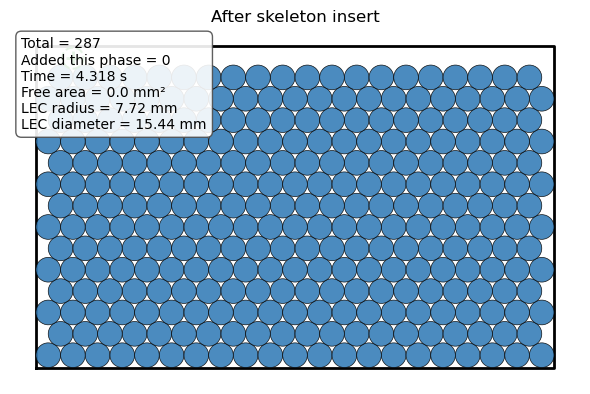

Area that could still host a centre: 9431.7 mm²
Largest empty circle radius: 2.13 mm (4.26 mm diameter)
Saved 287 circle centres to out.csv


In [2]:
poly, _ = cp.load_boundary(Path(json_file))

# 1 ─ aligned hex grid (finer phase scan gives 1-3 extra cells)
centres = cp.best_hex_seed_two_angles(poly, n_phase=16)
print("hex grid :", len(centres))

# pso refine (deleted for now, see below)
#centres1 = pso_refine(centres0, poly)
#print("PSO done")

# 2 ─ first greedy insertion (fills obvious edge gaps)
centres = cp.greedy_insert(poly, centres, trials=1000, max_pass=6)
print("after greedy :", len(centres))

# 3 ─ local compaction (Python re-implementation of Zhou’s batch-BFGS)
centres = cp.batch_bfgs_compact(centres, R, poly, n_pass=4)
print("after compaction :", len(centres))

# 4 ─ second greedy pass (micron pockets now opened by compactor)
centres = cp.greedy_insert(poly, centres, trials=1000, max_pass=3)
print("final count :", len(centres))

prev = len(centres)
t0 = cp.perf_counter()
centres = cp.skeleton_insert(poly, centres, step=2.0)
t1 = cp.perf_counter()
cp.plot_phase(poly, centres, added_idx=np.arange(prev, len(centres)),
        title="After skeleton insert", r=R, time_s=t1 - t0)

# ───▶  DIAGNOSTIC POCKET ANALYSIS  ◀─────────────────────────────────────
free     = poly.buffer(-R).buffer(0)            # safe interior strip
hull     = cp.unary_union([Point(x, y).buffer(R) for x, y in centres])
residual = free.difference(hull)

print(f"Area that could still host a centre: {residual.area:.1f} mm²")

# Optional: largest empty circle (Shapely≥2.0 only)
try:
    from shapely import maximum_inscribed_circle

    rad, centre_pt = cp.largest_empty_circle(residual)
    if rad > 0:
        print(f"Largest empty circle radius: {rad:.2f} mm "
            f"({2*rad:.2f} mm diameter)")
    else:
        print("Residual pocket too thin for even a tiny extra cell.")
except ImportError:
    pass
# ─────────────────────────────────────────────────────────────────────────

# 5 ─ save + preview
np.savetxt(out_csv, centres, delimiter=",", header="x,y", comments="")
print(f"Saved {centres.shape[0]} circle centres to {out_csv}")

row0, remaining cells for each block:3, a:3, b:3
still space to place a=3 cells (remaining space=21)
cid:0, gid:0, current group:0
cid:1, gid:0, current group:0
cid:2, gid:0, current group:0
3 cell placed (rem:18, n:1, cid:3)
still space to place b=3 cells (remaining space=18)
cid:3, gid:0, current group:1
cid:4, gid:0, current group:1
cid:5, gid:0, current group:1
3 cell placed (rem:15, n:2, cid:6)
row0, remaining cells for each block:3, a:3, b:3
still space to place a=3 cells (remaining space=15)
cid:6, gid:0, current group:2
cid:7, gid:0, current group:2
cid:8, gid:0, current group:2
3 cell placed (rem:12, n:3, cid:9)
still space to place b=3 cells (remaining space=12)
cid:9, gid:0, current group:3
cid:10, gid:0, current group:3
cid:11, gid:0, current group:3
3 cell placed (rem:9, n:4, cid:12)
row0, remaining cells for each block:3, a:3, b:3
still space to place a=3 cells (remaining space=9)
cid:12, gid:0, current group:4
cid:13, gid:0, current group:4
cid:14, gid:0, current group:4

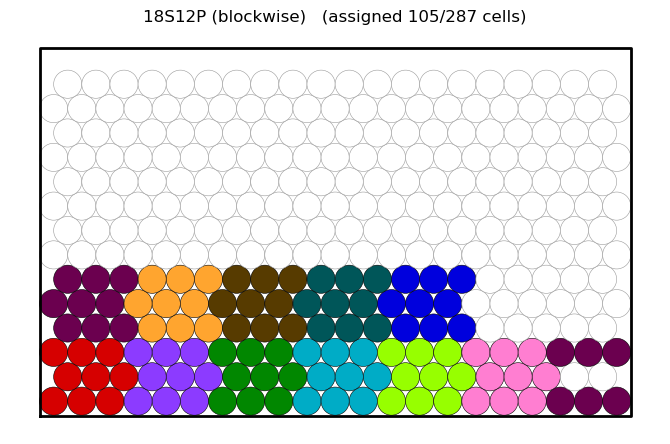

In [ ]:
import k_grouping_new as gn
from collections import Counter


# 1) load your CSV of centres (x,y)
centres = np.loadtxt("out.csv", delimiter=",", skiprows=1)

# 2) infer rows from geometry
R = 9.0
rows = gn.build_rows_from_centres(centres, R)

# 3) choose x,y
x = 11
y = 9

# 4) group
part_of, groups = gn.group_xSyP_strict_reading(rows, x, y)

# (optional) check
assert len(groups) == x
#assert all(len(g) == y for g in groups)


sizes = Counter(part_of.values())
print("Group sizes:", [sizes[g] for g in sorted(sizes)])  # should be [12,12,...] 18 times
print("Assigned cells:", sum(sizes.values()))
print("Distinct groups used:", len(sizes))

assigned_idx = sorted(part_of.keys())
gn.plot_groups_blockwise(
    centres, part_of, poly,
    R=9.0, S=x, title=f"{x}S{y}P (blockwise)",
    show_labels=True, label_unassigned=False, fontsize=6
)



Kept 100 cells, discarded 187 extras


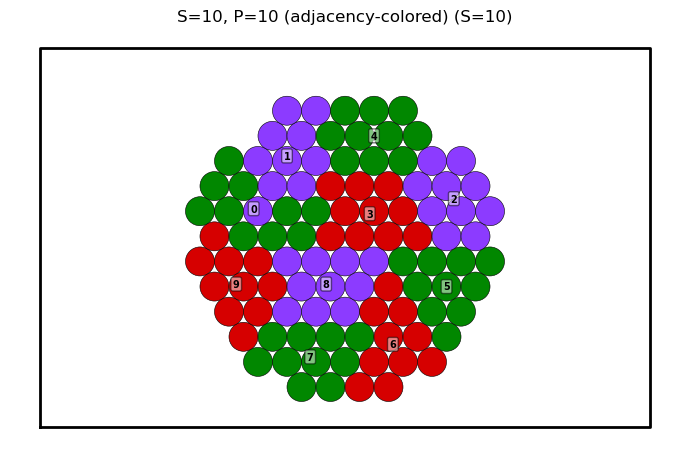

In [4]:
centres_all = kg.load_centres(Path("out.csv"))
N_all = len(centres_all)

# ----- SELECT EXACTLY S*P CELLS ------------------------------------
keep_mask = kg.drop_periphery_iterative(centres_all, S*P)
centres   = centres_all[keep_mask]        # array of shape (S*P,2)
print(f"Kept {len(centres)} cells, discarded {N_all-len(centres)} extras")

# -------------------------------------------------------------------
G   = kg.build_contact_graph(centres)        # only those kept cells
#parts = metis_k_partition(G, S)           # S balanced parts
#parts = geodesic_capacity_partition(G, S, P)
#part_of = metis_connected_parts(G, S, P)   # healing on top of METIS

# parts is a list (len = S*P).  Convert to dict {node_id: group_id}
#part_dict = {i:part_of[i] for i in range(len(part_of))}
kg.rb_exact_partition.gid_counter = 0
part_of = kg.rb_exact_partition(G, list(G.nodes()), P)

group_color = kg.color_groups_avoiding_adjacent(G, part_of, S)


# ----- Sanity check -------------------------------------------------
#group_sizes = [parts.count(g) for g in range(S)]
#group_sizes = [list(part_of.values()).count(g) for g in range(S)]
#print("Group sizes:", group_sizes)        # should all be P

# ----- PLOT ---------------------------------------------------------
kg.plot_groups(poly, centres, part_of, S, group_color=group_color, title=f"S={S}, P={P} (adjacency-colored)")
# ----------------------------------------------------------------------



Series order: [5, 6, 7, 8, 9, 0, 1, 4, 3, 2]
Polarity: {5: 1, 6: -1, 7: 1, 8: -1, 9: 1, 0: -1, 1: 1, 4: -1, 3: 1, 2: -1}


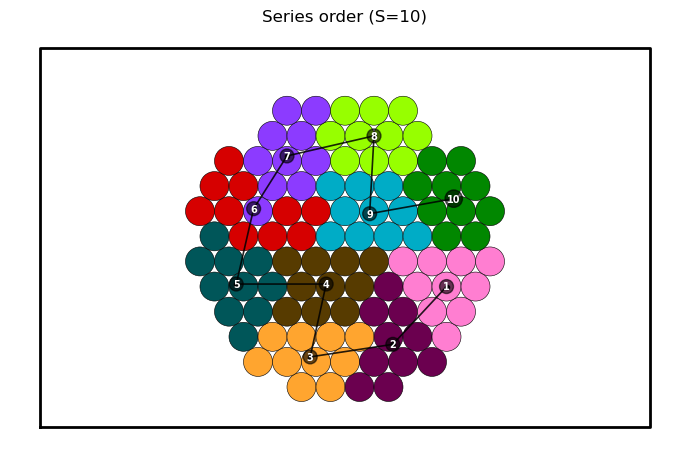

In [5]:
import series_ordering as so

order, group_edges = so.series_order_ortools(G, centres, part_of, beta=0.05, time_limit_s=5)
print("Series order:", order)
# Optional polarity (+1, -1 alternating)
polarity = {g: (1 if i % 2 == 0 else -1) for i, g in enumerate(order)}
print("Polarity:", polarity)

# Plot
group_color = kg.color_groups_avoiding_adjacent(G, part_of, S)
so.plot_series_order(poly, centres, part_of, S, order, R=R)

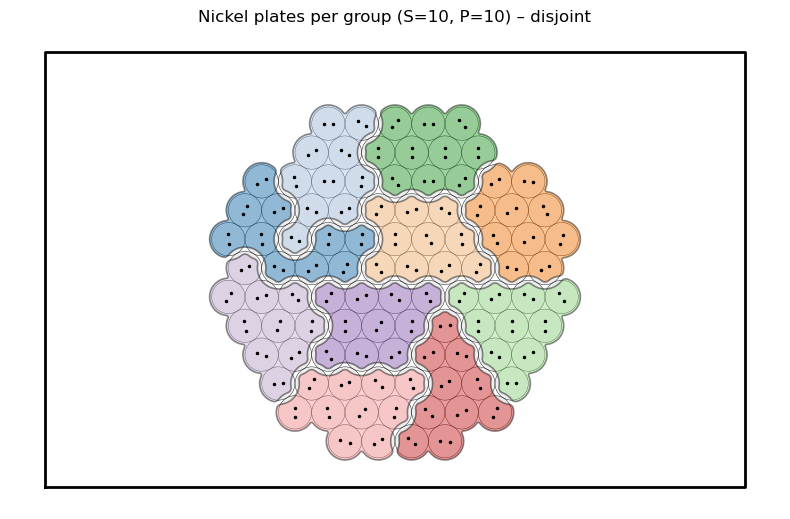

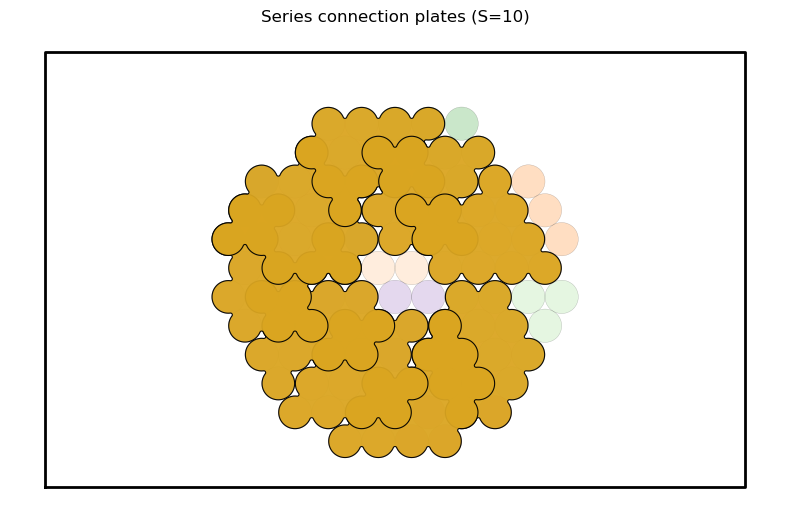

In [6]:
plates = pp.make_all_plates(G, centres, part_of, S,
                                R=R, land=1.2, gap=2.0, outline=poly, res=64)
plates = {g: pp.smooth_plate(poly, r_open=3, r_close=1, gap=2.0, safety=0.10)
      for g, poly in plates.items()}
#plate = npb.smooth_plate(plates, r_open=0.8, r_close=0.4, gap=2.0, safety=0.10)
welds  = pp.weld_points_all(G, centres, part_of, S, R=R, offset=2.6)
# Plot
pp.plot_plates(poly, centres, part_of, S, plates, welds, R=R,
                title=f"Nickel plates per group (S={S}, P={P}) – disjoint")


#-----------------------------------Series--------------------------------
# known:
#   plates : dict {group -> shapely Polygon}  (parallel plates, disjoint)
#   part_of, centres, S
#   order  : list of group-ids from OR-Tools path
#   I_pack : (estimated) peak pack current

group_edges = [(order[i], order[i+1]) for i in range(len(order)-1)]


bridges = sp.make_series_band_from_cells(
    G, centres, part_of, group_edges,
    R=9.0,
    rows=1,        # try 2–3 to match your photo (more rows ⇒ wider plate)
    inset=0.2,
    smooth=1.0,
    clip_poly=poly
)

sp.plot_series_plates_over_cells(poly, centres, part_of, S, bridges, R=9.0)